In [1]:
# Matplotlib for plotting
%matplotlib inline
from matplotlib import pyplot as plt

# Numpy for almost everything
import numpy as np

# Some scipy functions for sparse diagonal matrices
from scipy.sparse import diags

# scipy function to numerically calculate integral
from scipy.integrate import simps

# By using trange instead of range, we get a nice progress bar
from tqdm import trange

# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
from numba import jit

from scipy.integrate import quadrature

from scipy.integrate import quad

from scipy.integrate import fixed_quad

In [2]:
#used the thomas algorithm, taken from another course


# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    # Note, this method needs A to be diagonally dominant
    # (which it will be, for this problem)
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

In [3]:
#a function for solving the linear system
#due to the boundaries, we still need to solve u(x) = û(x) + Rh(x)
#Rh(x) is equivalent to d1*phi_0(x) + d2*phi_M+1(x)
def FEM_coeffs(f,d1,d2,X):
    
    N = len(X)
    
    sides = -1/(X[2:-1]-X[1:-2])
    main = (1/(X[1:-1]-X[:-2])) +(1/(X[2:]-X[1:-1]))
    
    A = diags(diagonals = [sides, main, sides], offsets = [1,0,-1],format = "csc")
    
    #initializing the U-vector
    Us = np.zeros(N)
    Us[0] = d1
    Us[-1] = d2
    
    F = np.zeros(N-2)
    
    for i in range(N-2):
        #making functions for the separate parts of the equation
        g1 = lambda x: (x-X[i])*f(x)
        g2 = lambda x: (X[i+2]-x)*f(x)
        
        #using a built-in function from scipy to obtain gaussian quadrature
        g1_int = quad(g1,X[i],X[i+1])
        g2_int = quad(g2,X[i+1],X[i+2])
        
        #this should be equivalent to dividing by h
        #so it holds for the nonuniform case as well
        F[i] = (g1_int[0]*(1/(X[i+1]-X[i])) + g2_int[0]*(1/(X[i+2]-X[i+1])))
    
    
    F[0] += (d1/(X[1]-X[0]))
    F[-1] += (d2/(X[-1]-X[-2]))
    Us[1:-1] = tdma(A,F)
    return Us

In [4]:
def f1(x):
    return -2*np.ones_like(x)

def f1_a(x):
    return x**2

def f2(x):
    return -(40000*x**2 - 200)*np.exp(-100*x**2)

def f2_a(x):
    return np.exp(-100 * x**2)

def f3(x):
    return -(4000000*x**2 - 2000)*np.exp(-1000*x**2)

def f3_a(x):
    return np.exp(-1000 * x**2)

def f4(x):
    return (2/9)*x**(-4/3)

def f4_a(x):
    return x**(2/3)

In [5]:
def FEM_spline_vals(Us, X, xs):
    if np.isscalar(xs) == True:
        xs = np.array([xs])
    vals = np.zeros(len(xs))
    j=0
    for x in xs:
        i = np.argmax(X>=x)
        if X[i] == x:
            vals[j] = Us[i]*(x-X[i-1])/(X[i] - X[i-1])
        else:
            vals[j] = (Us[i-1]*((X[i]-x)/(X[i]-X[i-1])) + Us[i]*((x-X[i-1])/(X[i]-X[i-1])) )
        j+=1
    return vals


1.283404287605563e-05


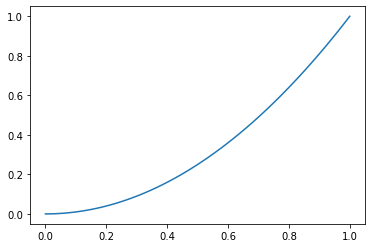

In [6]:
N=100
X1 = np.linspace(0,1,N)

Us = FEM_coeffs(f1,0,1,X1)

#tester ut L2 error for disse
#dvs tester ut for f1num
u_num = lambda x: FEM_spline_vals(Us, X1, x)
upper = lambda x: (u_num(x) - f1_a(x))**2
print(np.sqrt(quadrature(upper,0,1)[0])/np.sqrt(quadrature(f1_a,0,1)[0]))

plt.plot(X1,u_num(X1))

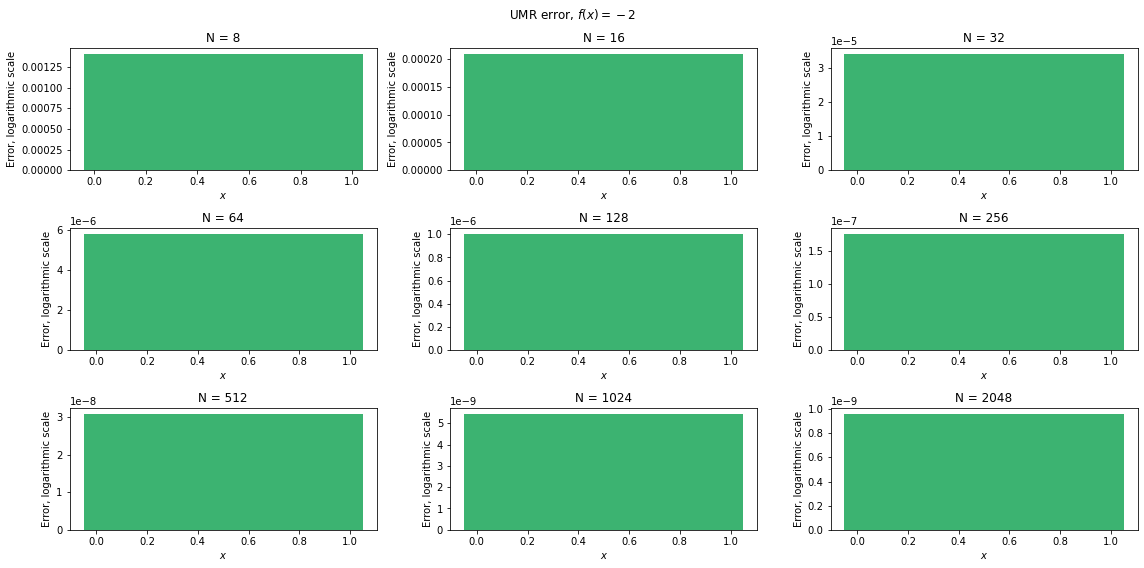

In [108]:
n_lst = 2 ** (np.linspace(3,11,9,dtype=int))

#making a loglog plot for the 1st eqn
err_lst1 = np.zeros(len(n_lst))
i=0

#making a pretty picture
plt.figure(figsize = (16,8))
xs = np.linspace(0,1,1000)
#running the for loop
for n in n_lst:
    X1 = np.linspace(0,1,n)
    Us1 = FEM_coeffs(f1,0,1,X1)
    #interpolating to find the L2 error
    u_num = lambda x: FEM_spline_vals(Us1, X1, x)
    upper = lambda x: (u_num(x) - f1_a(x))**2
    spline_err = np.zeros(n-1)
    for j in range(len(X1)-1):
        spline_err[j] = np.sqrt(quad(upper,X1[j],X1[j+1])[0])
    
    
    plt.subplot(3,3,i+1)
    plt.suptitle("UMR error, $f(x)=-2$")
    """plt.plot(X1,u_num(X1),"-o",color="mediumseagreen")
    plt.plot(xs,f1_a(xs),"--k")"""
    plt.xlabel("$x$")
    plt.ylabel("Error, logarithmic scale")
    #plt.ylabel("U$(x)$")
    plt.title("N = "+str(n))
    plt.bar(0.5*(X1[1:]+X1[:-1]),spline_err,width=(0.1+(X1[-1]-X1[0])/len(X1)),log=False,color="mediumseagreen")
    
    #lower = lambda x: f1_a(x)**2
    #updating the error list
    err_lst1[i] =np.sqrt(quad(upper,0,1)[0])#/np.sqrt(quad(lower,0,1)[0])
    i+=1
"""plt.plot(X1,u_num(X1),"-o",color="mediumseagreen",label="Numerical")
plt.plot(xs,f1_a(xs),"--k",label="Analytical")"""
plt.tight_layout()
"""plt.figlegend(ncol=np.int(3), labelspacing=0. )"""
plt.savefig('5b_umrerr.png')
plt.show()

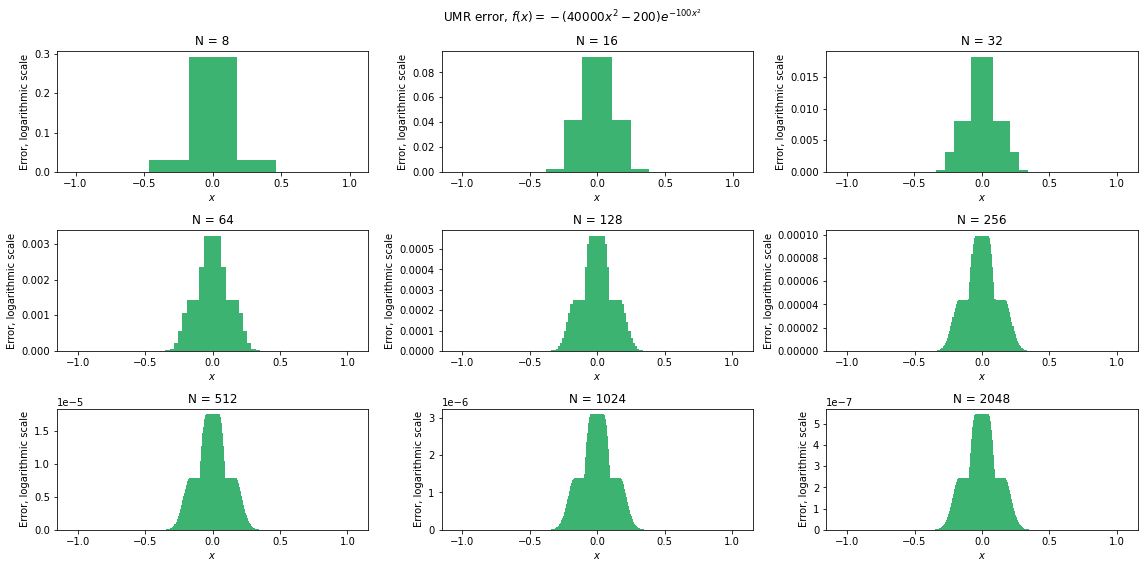

In [109]:
#making a loglog plot for the 2nd eqn
err_lst2 = np.zeros(len(n_lst))
i=0
xs = np.linspace(-1,1,1000)
plt.figure(figsize = (16,8))
#running the for loop
for n in n_lst:
    X2 = np.linspace(-1,1,n)
    Us2 = FEM_coeffs(f2,np.exp(-100),np.exp(-100),X2)
    #interpolating to find the L2 error
    u_num = lambda x: FEM_spline_vals(Us2, X2, x)
    upper = lambda x: (u_num(x) - f2_a(x))**2
    spline_err = np.zeros(n-1)
    #lower = lambda x: f2_a(x)**2
    
    for j in range(len(X2)-1):
        spline_err[j] = np.sqrt(quad(upper,X2[j],X2[j+1])[0])
    
    plt.subplot(3,3,i+1)
    plt.suptitle("UMR error, $f(x)=-(40000x^2-200)e^{-100x^2}$")
    
    """plt.plot(X2,u_num(X2),"-o",color="mediumseagreen")
    plt.plot(xs,f2_a(xs),"--k")"""
    plt.xlabel("$x$")
    plt.ylabel("Error, logarithmic scale")
    #plt.ylabel("U$(x)$")
    plt.title("N = "+str(n))
    plt.bar(0.5*(X2[1:]+X2[:-1]),spline_err,width=(0.1+(X2[-1]-X2[0])/len(X2)),log=False,color="mediumseagreen")

    #updating the error list
    err_lst2[i] =np.sqrt(quad(upper,-1,1)[0])#/np.sqrt(quad(lower,-1,1)[0])
    i+=1
"""plt.plot(X2,u_num(X2),"-o",color="mediumseagreen",label="Numerical")
plt.plot(xs,f2_a(xs),"--k",label="Analytical")"""
plt.tight_layout()
#plt.figlegend(ncol=np.int(3), labelspacing=0. )
plt.savefig('5c_umrerr.png')
plt.show()

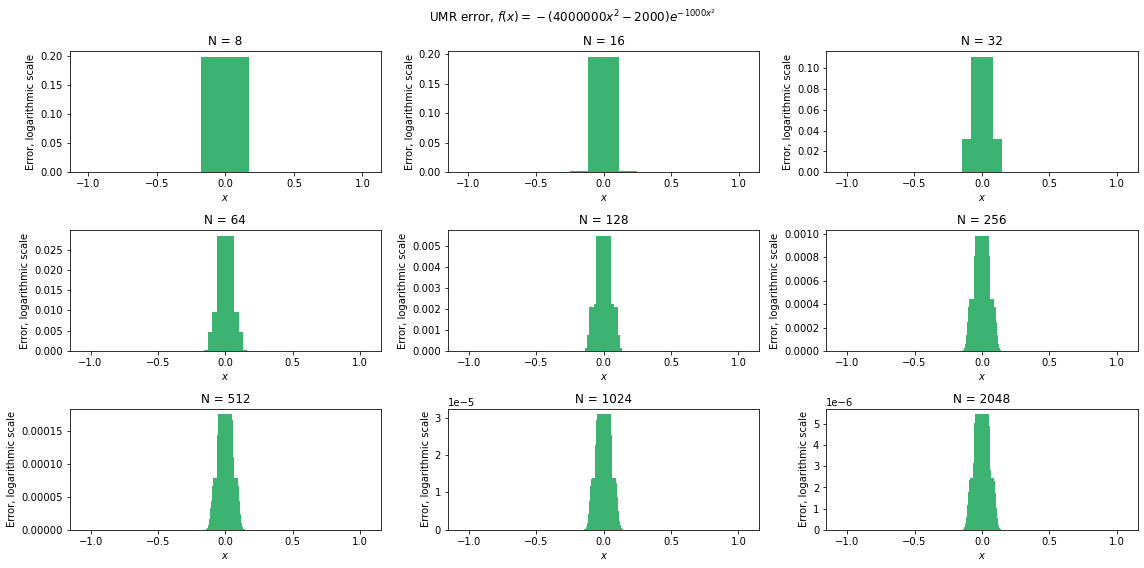

In [110]:
#making a loglog plot for the 2nd eqn
err_lst3 = np.zeros(len(n_lst))
i=0
xs = np.linspace(-1,1,1000)
plt.figure(figsize = (16,8))
#running the for loop
for n in n_lst:
    X3 = np.linspace(-1,1,n)
    spline_err=np.zeros(n-1)
    Us3 = FEM_coeffs(f3,np.exp(-1000),np.exp(-1000),X3)
    #interpolating to find the L2 error
    u_num = lambda x: FEM_spline_vals(Us3, X3, x)
    upper = lambda x: (u_num(x) - f3_a(x))**2
    
    for j in range(len(X3)-1):
        spline_err[j] = np.sqrt(quad(upper,X3[j],X3[j+1])[0])
    plt.subplot(3,3,i+1)
    plt.suptitle("UMR error, $f(x)=-(4000000x^2-2000)e^{-1000x^2}$")
    #plt.plot(X3,u_num(X3),"-o",color="mediumseagreen")
    #plt.plot(xs,f3_a(xs),"--k")
    plt.xlabel("$x$")
    plt.ylabel("Error, logarithmic scale")
    plt.bar(0.5*(X3[1:]+X3[:-1]),spline_err,width=(0.1+(X3[-1]-X3[0])/len(X3)),log=False,color="mediumseagreen")
    
    #plt.ylabel("U$(x)$")
    plt.title("N = "+str(n))
    
    #lower = lambda x: f3_a(x)**2
    #updating the error list
    err_lst3[i] =np.sqrt(quad(upper,-1,1)[0])#/np.sqrt(quad(lower,-1,1)[0])
    i+=1
"""plt.plot(X3,u_num(X3),"-o",color="mediumseagreen",label="Numerical")
plt.plot(xs,f3_a(xs),"--k",label="Analytical")"""
plt.tight_layout()
#plt.figlegend(ncol=np.int(3), labelspacing=0. )
plt.savefig('5d_umrerr.png')
plt.show()

C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: IntegrationWarning: The integral is probably divergent, or slowly convergent.


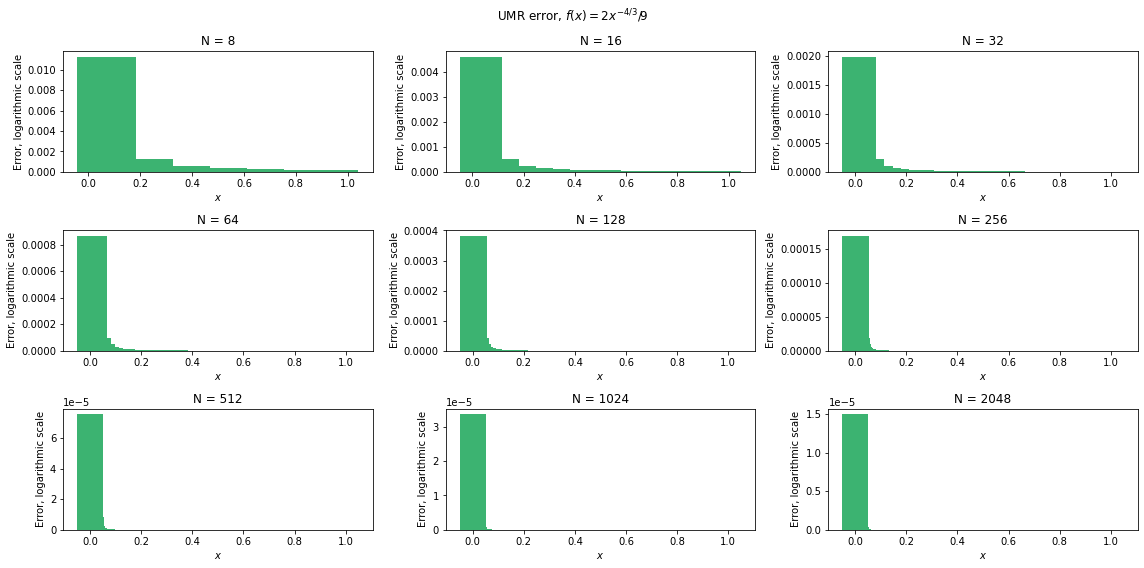

In [111]:
#making a loglog plot for the 2nd eqn
err_lst4 = np.zeros(len(n_lst))
i=0
xs = np.linspace(0,1,1000)
plt.figure(figsize = (16,8))
#running the for loop
for n in n_lst:
    X4 = np.linspace(0,1,n)
    Us4 = FEM_coeffs(f4,0,1,X4)
    #interpolating to find the L2 error
    u_num = lambda x: FEM_spline_vals(Us4, X4, x)
    upper = lambda x: (u_num(x) - f4_a(x))**2
    
    spline_err=np.zeros(n-1)
    
    for j in range(len(X4)-1):
        spline_err[j] = np.sqrt(quad(upper,X4[j],X4[j+1])[0])
    
    
    plt.subplot(3,3,i+1)
    plt.suptitle("UMR error, $f(x)=2x^{-4/3}/9$")
    """plt.plot(X4,u_num(X4),"-o",color="mediumseagreen")
    plt.plot(xs,f4_a(xs),"--k")"""
    plt.xlabel("$x$")
    plt.ylabel("Error, logarithmic scale")
    #plt.ylabel("U$(x)$")
    plt.title("N = "+str(n))
    plt.bar(0.5*(X4[1:]+X4[:-1]),spline_err,width=(0.1+(X4[-1]-X4[0])/len(X4)),log=False,color="mediumseagreen")
    
    #lower = lambda x: f4_a(x)**2
    #updating the error list
    err_lst4[i] =np.sqrt(quad(upper,0,1)[0])#/np.sqrt(quad(lower,0,1)[0])
    i+=1
"""plt.plot(X4,u_num(X4),"-o",color="mediumseagreen",label="Numerical")
plt.plot(xs,f4_a(xs),"--k",label="Analytical")"""
plt.tight_layout()
#plt.figlegend(ncol=np.int(3), labelspacing=0. )
plt.savefig('5e_umrerr.png')
plt.show()

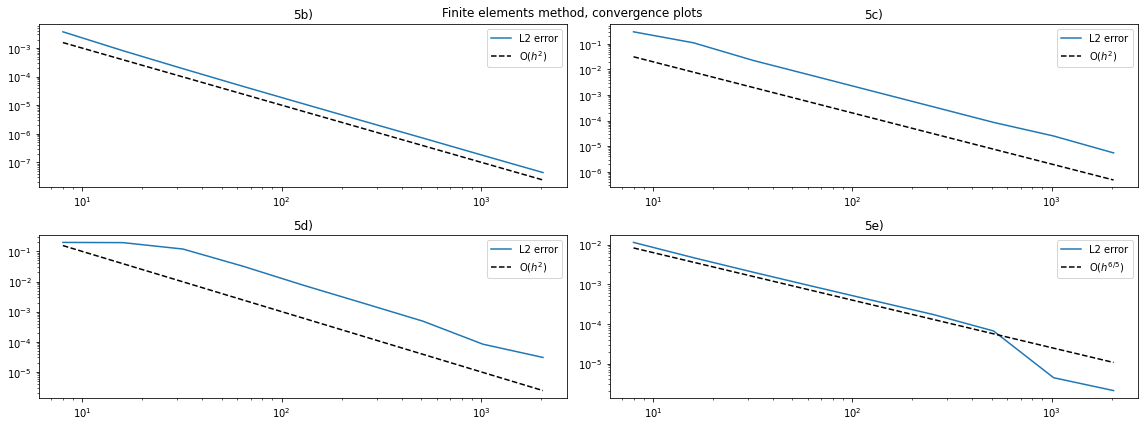

In [11]:
plt.figure(figsize = (16,6))

plt.subplot(2,2,1)
plt.title("5b)")
plt.loglog(n_lst,err_lst1, label="L2 error")
plt.loglog(n_lst,0.1*1/(n_lst)**2,"--k", label="O($h^2$)")
plt.legend()
plt.subplot(2,2,2)
plt.title("5c)")
plt.loglog(n_lst,err_lst2, label="L2 error")
plt.loglog(n_lst,2*1/(n_lst)**2,"--k", label="O($h^2$)")
plt.legend()
plt.subplot(2,2,3)
plt.title("5d)")
plt.loglog(n_lst,err_lst3, label="L2 error")
plt.loglog(n_lst,10*1/(n_lst)**2,"--k", label="O($h^2$)")
plt.legend()
plt.subplot(2,2,4)
plt.title("5e)")
plt.loglog(n_lst,err_lst4, label="L2 error")
plt.loglog(n_lst,0.1 * 1/(n_lst)**(6/5),"--k", label="O($h^{6/5}$)")
plt.legend()
plt.tight_layout()
plt.suptitle("Finite elements method, convergence plots")
plt.show()

In [113]:
def avg_AFEM(f,f_a,d1,d2,X,err_tol):
    Us = FEM_coeffs(f,d1,d2,X)
    #the function u_num is basically finding the spline and the coefficients
    #so it can be used when traversing through the different splines
    u_num = lambda x: FEM_spline_vals(Us, X, x)
    #making a list to store the errors and degrees of freedom in
    #so the 1st column will be 
    dof_err = np.zeros((32,2))
    
    xs = np.linspace(X[0],X[-1],1000)
    
    spline_err = np.zeros(len(X)-1)
    #making a pretty picture
    plt.figure(figsize = (16,16))
    plt.subplot(8,4,1)
    plt.suptitle("AFEM error - Average strategy")
    """plt.plot(X,u_num(X),"-o",color='c',label="Numerical")
    plt.plot(xs,f_a(xs),"--k",label="Analytical")"""
    plt.xlabel("$x$")
    plt.ylabel("Error")
    #plt.ylabel("U$(x)$")
    plt.title("Step 0")
    #diff can be used for all functions: it's the quadrature formula that will change
    diff = lambda x: (u_num(x) - f_a(x))**2

    #finding the error for the whole function
    total_err = np.sqrt(quad(diff,X[0],X[-1])[0])
    #rhs = 1 *total_err/len(X)

    dof_err[0,0] = len(X)
    dof_err[0,1] = total_err
    

    #traversing through the different splines to find the error
    for i in range(len(X)-1):
        spline_err[i] = np.sqrt(quad(diff,X[i],X[i+1])[0])
    plt.bar(0.5*(X[1:]+X[:-1]),spline_err,width=(0.1+X[-1]-X[0])/len(X),color='c',log=False)

    rhs = total_err/(len(X)-1)
        
    split_these = np.argwhere(spline_err>rhs)[:,0]
    
    #sorting from last to first so that adding an element wont affect the rest of the indices
    split_these = np.sort(split_these)[::-1]

    j=1
    #while (j<12) and len(split_these!=0):
    while total_err>err_tol and len(split_these!=0):
        for i in split_these:
            X = np.insert(X,i+1,0.5*(X[i]+X[i+1]))

        Us = FEM_coeffs(f,d1,d2,X)
        u_num = lambda x: FEM_spline_vals(Us, X, x)
        
        #making a pretty picture
        plt.subplot(8,4,j+1)
        """
        plt.plot(X,u_num(X),"-o",color='c')
        plt.plot(xs,f_a(xs),"--k")"""
        plt.xlabel("$x$")
        #plt.ylabel("U$(x)$")
        plt.ylabel("Error")
        plt.title("Step " + str(j))


        #diff can be used for all functions: it's the quadrature formula that will change
        diff = lambda x: (u_num(x) - f_a(x))**2
        #finding the error for the whole function
        total_err = np.sqrt(quad(diff,X[0],X[-1])[0])
        
        rhs = total_err/(len(X)-1)

        dof_err[j,0] = len(X)
        dof_err[j,1] = total_err

        spline_err = np.zeros(len(X)-1)

        #traversing through the different splines to find the error
        for i in range(len(X)-1):
            spline_err[i] = np.sqrt(quad(diff,X[i],X[i+1])[0])

        plt.bar(0.5*(X[1:]+X[:-1]),spline_err,width=(0.1+(X[-1]-X[0])/len(X)),color='c',log=False)
        
        split_these = np.argwhere(spline_err>rhs)[:,0]
        
        """print("Right hand side: ", rhs)
        print("Spline errors: ", spline_err)
        print("Splitting: ", X[split_these])"""
        
        #sorting from last to first so that adding an element wont affect the rest of the indices
        split_these = np.sort(split_these)[::-1]
        j+=1
    plt.tight_layout()
    #plt.figlegend(ncol=np.int(j/2), labelspacing=0. )
    plt.savefig(str(f.__name__)+"avgerr.png",bbox_inches="tight")
    plt.show()
    
    return dof_err[:j,:j]

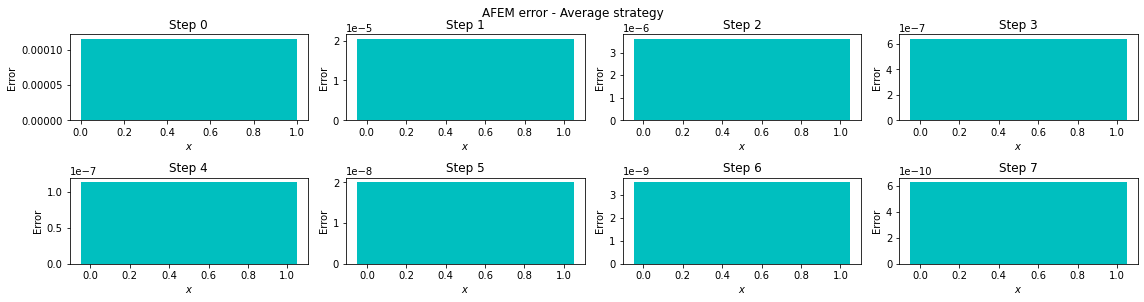

In [114]:
N=20
d1 = 0
d2 = 1
X1 = np.linspace(0,1,N)

dof_err_avg1 = avg_AFEM(f1,f1_a,d1,d2,X1,err_lst1[-1])

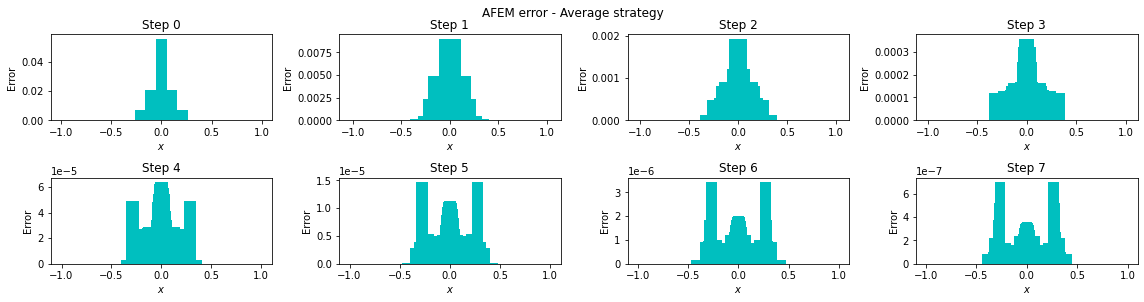

In [115]:
N=20
d1 = np.exp(-100)
d2 = np.exp(-100)
X2 = np.linspace(-1,1,N)

dof_err_avg2 = avg_AFEM(f2,f2_a,d1,d2,X2,err_lst2[-1])


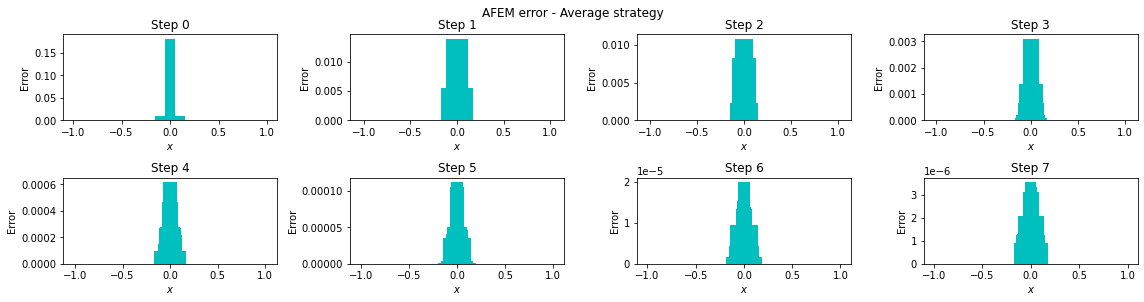

In [116]:
N=20
d1 = np.exp(-1000)
d2 = np.exp(-1000)
X3 = np.linspace(-1,1,N)

dof_err_avg3 = avg_AFEM(f3,f3_a,d1,d2,X3,err_lst3[-1])


C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: IntegrationWarning: The integral is probably divergent, or slowly convergent.


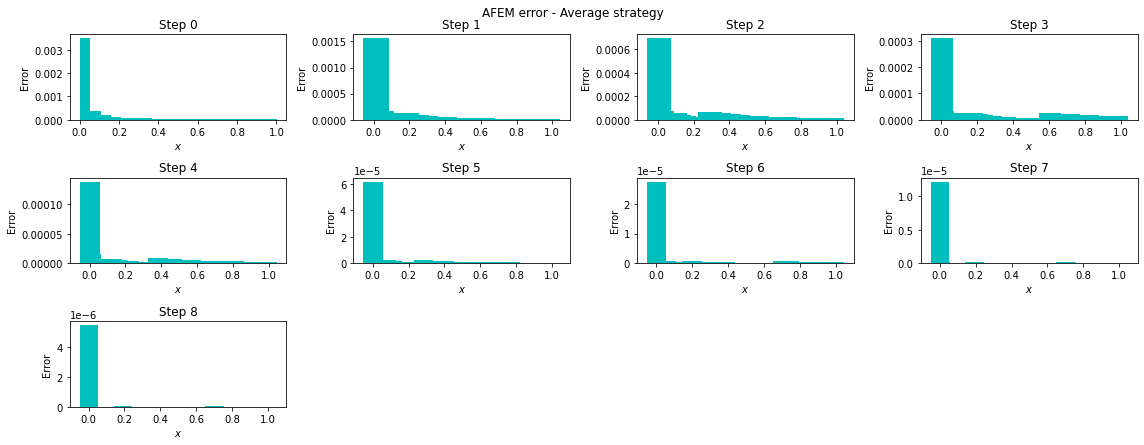

In [117]:
N=20
d1 = 0
d2 = 1
X4 = np.linspace(0,1,N)

dof_err_avg4 = avg_AFEM(f4,f4_a,d1,d2,X4,err_lst4[-1])


In [118]:
def max_AFEM(f,f_a,d1,d2,X,err_tol):
    Us = FEM_coeffs(f,d1,d2,X)
    #the function u_num is basically finding the spline and the coefficients
    #so it can be used when traversing through the different splines
    u_num = lambda x: FEM_spline_vals(Us, X, x)
    #making a list to store the errors and degrees of freedom in
    #so the 1st column will be 
    dof_err = np.zeros((32,2))
    
    spline_err = np.zeros(len(X)-1)
    
    xs = np.linspace(X[0],X[-1],1000)
    
    plt.figure(figsize = (16,16))
    plt.subplot(8,4,1)
    """plt.plot(X,u_num(X),"-o",color='darkviolet',label="Numerical")
    plt.plot(xs,f_a(xs),"--k",label="Analytical")"""
    plt.xlabel("$x$")
    #plt.ylabel("U$(x)$")
    plt.ylabel("Error")
    plt.suptitle("AFEM error - Maximum strategy")
    plt.title("Step 0")
    #diff can be used for all functions: it's the quadrature formula that will change
    diff = lambda x: (u_num(x) - f_a(x))**2

    #finding the error for the whole function
    total_err = np.sqrt(quad(diff,X[0],X[-1])[0])

    dof_err[0,0] = len(X)
    dof_err[0,1] = total_err

    #traversing through the different splines to find the error
    for i in range(len(X)-1):
        spline_err[i] = np.sqrt(quad(diff,X[i],X[i+1])[0])

    plt.bar(0.5*(X[1:]+X[:-1]),spline_err,width=(0.1+(X[-1]-X[0])/len(X)),color='darkviolet',log=False)
    #using alfa=0.7 and the maximum spline multiplied together on the right hand side
    rhs = 0.7 * np.amax(spline_err)
    
    split_these = np.argwhere(spline_err>rhs)[:,0]
    #sorting from last to first so that adding an element wont affect the rest of the indices
    split_these = np.sort(split_these)[::-1]

    j=1
    #while (j<12) and len(split_these!=0):
    while total_err>err_tol and len(split_these!=0):
        for i in split_these:
            X = np.insert(X,i+1,0.5*(X[i]+X[i+1]))

        Us = FEM_coeffs(f,d1,d2,X)
        u_num = lambda x: FEM_spline_vals(Us, X, x)

        #making a pretty picture
        plt.subplot(8,4,j+1)
        """plt.plot(X,u_num(X),"-o",color='darkviolet')
        plt.plot(xs,f_a(xs),"--k")"""
        plt.xlabel("$x$")
        plt.ylabel("Error")
        #plt.ylabel("U$(x)$")
        plt.title("Step " + str(j))


        #diff can be used for all functions: it's the quadrature formula that will change
        diff = lambda x: (u_num(x) - f_a(x))**2

        #finding the error for the whole function
        total_err = np.sqrt(quad(diff,X[0],X[-1])[0])
        dof_err[j,0] = len(X)
        dof_err[j,1] = total_err

        spline_err = np.zeros(len(X)-1)

        #traversing through the different splines to find the error
        for i in range(len(X)-1):
            spline_err[i] = np.sqrt(quad(diff,X[i],X[i+1])[0])
        plt.bar(0.5*(X[1:]+X[:-1]),spline_err,width=(0.1+(X[-1]-X[0])/len(X)),color='darkviolet',log=False)


        rhs = 0.7 * np.amax(spline_err)
        split_these = np.argwhere(spline_err>rhs)[:,0]

        #sorting from last to first so that adding an element wont affect the rest of the indices
        split_these = np.sort(split_these)[::-1]
        j+=1
    plt.tight_layout()
    plt.savefig(str(f.__name__)+"maxerr.png",bbox_inches="tight")
    plt.figlegend(ncol=np.int(j/2), labelspacing=0. )
    plt.show()
    
    return dof_err[:j,:j]

No handles with labels found to put in legend.


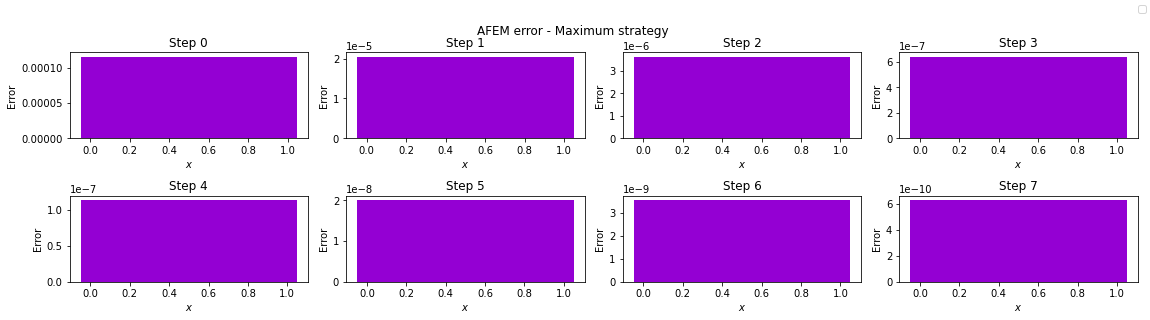

In [119]:
N=20
d1 = 0
d2 = 1
X1 = np.linspace(0,1,N)

dof_err_max1 = max_AFEM(f1,f1_a,d1,d2,X1,err_lst1[-1])

No handles with labels found to put in legend.


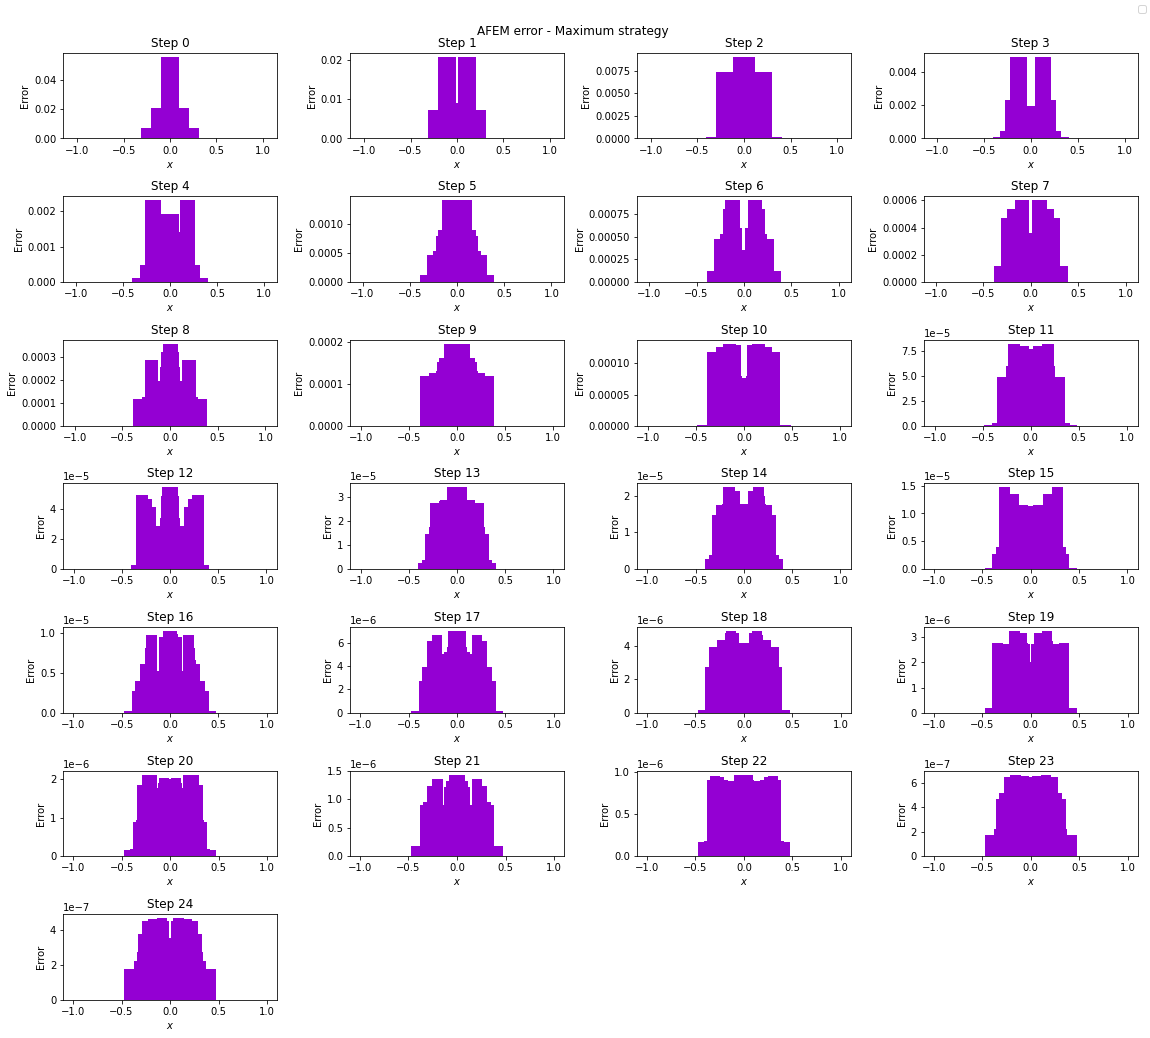

In [120]:
N=20
d1 = np.exp(-100)
d2 = np.exp(-100)
X2 = np.linspace(-1,1,N)

dof_err_max2 = max_AFEM(f2,f2_a,d1,d2,X2,err_lst2[-1])

No handles with labels found to put in legend.


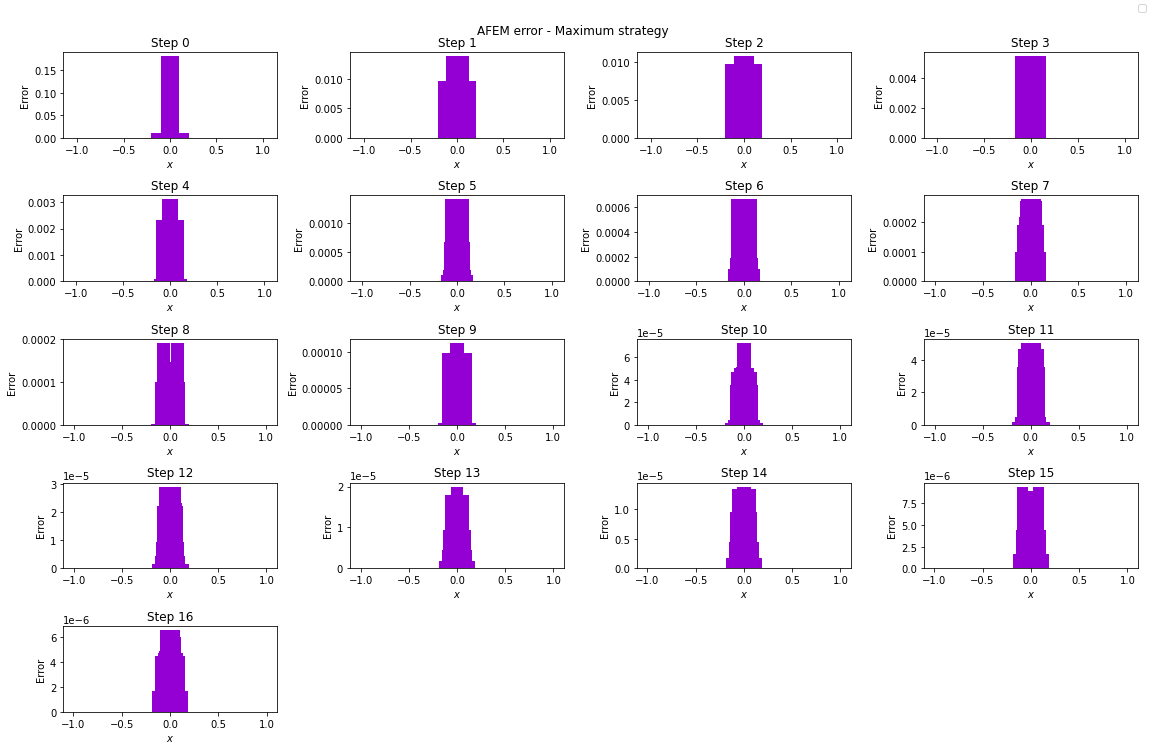

In [121]:
N=20
d1 = np.exp(-1000)
d2 = np.exp(-1000)
X3 = np.linspace(-1,1,N)

dof_err_max3 = max_AFEM(f3,f3_a,d1,d2,X3,err_lst3[-1])

No handles with labels found to put in legend.


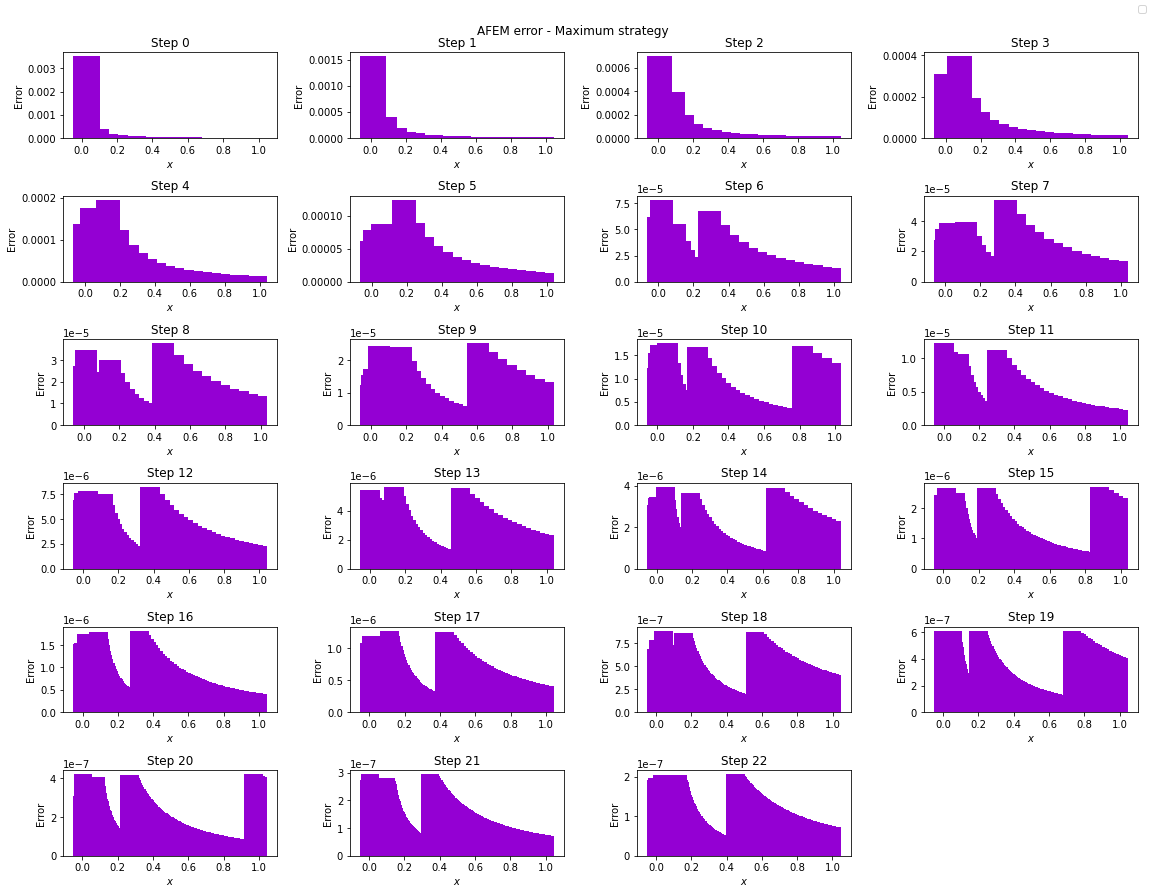

In [122]:
N=20
d1 = 0
d2 = 1
X4 = np.linspace(0,1,N)

dof_err_max4 = max_AFEM(f4,f4_a,d1,d2,X4,err_lst4[-1])


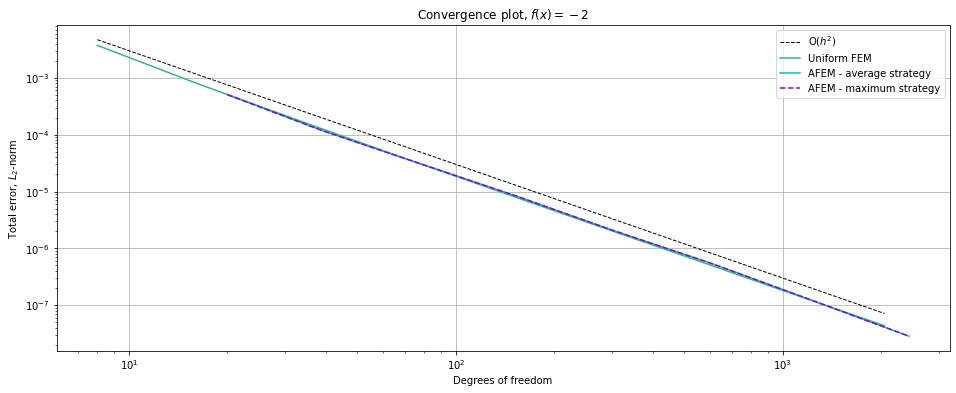

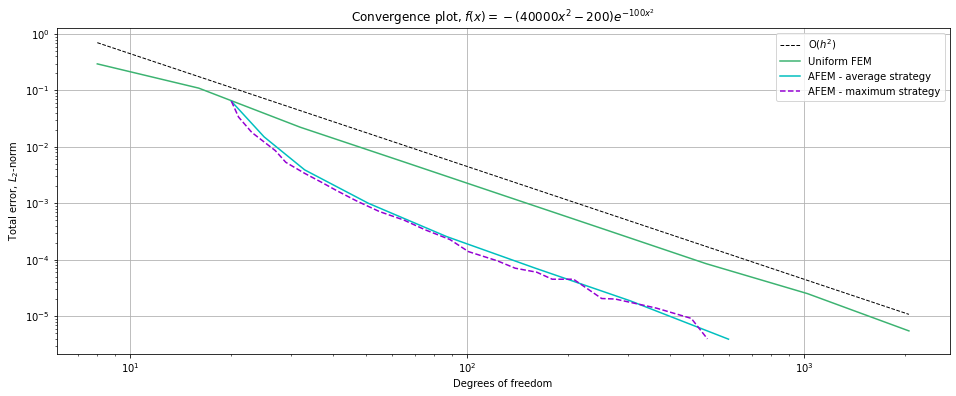

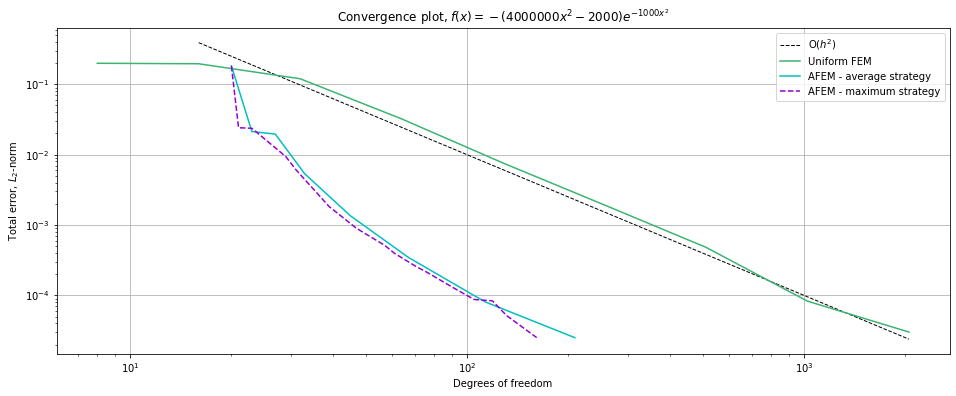

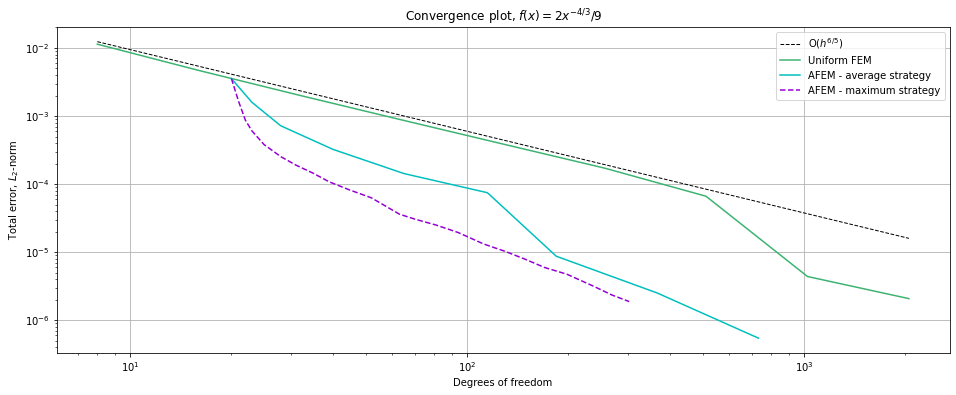

In [127]:
#Plotting the different loglog graphs all together
plt.figure(figsize=(16,6))
plt.title("Convergence plot, $f(x)=-2$")
plt.loglog(n_lst,3e-1*1/n_lst**2,"--k",label="O($h^2$)",linewidth=1)
plt.loglog(n_lst, err_lst1,color="mediumseagreen", label="Uniform FEM")
plt.loglog(dof_err_avg1[:,0], dof_err_avg1[:,1],"c", label="AFEM - average strategy")
plt.loglog(dof_err_max1[:,0], dof_err_max1[:,1],"--",color='darkviolet', label="AFEM - maximum strategy")
plt.ylabel("Total error, $L_2$-norm")
plt.xlabel("Degrees of freedom")
plt.legend()
plt.grid()
plt.savefig("5b.png",bbox_inches="tight")
plt.show()

plt.figure(figsize=(16,6))
plt.title("Convergence plot, $f(x)=-(40000x^2-200)e^{-100x^2}$")
plt.loglog(n_lst,45*1/n_lst**2,"--k",label="O($h^2$)",linewidth=1)
plt.loglog(n_lst, err_lst2,color="mediumseagreen", label="Uniform FEM")
plt.loglog(dof_err_avg2[:,0], dof_err_avg2[:,1],"c", label="AFEM - average strategy")
plt.loglog(dof_err_max2[:,0], dof_err_max2[:,1],"--",color="darkviolet", label="AFEM - maximum strategy")
plt.ylabel("Total error, $L_2$-norm")
plt.xlabel("Degrees of freedom")
plt.legend()
plt.grid()
plt.savefig("5c.png",bbox_inches="tight")
plt.show()

plt.figure(figsize=(16,6))
plt.title("Convergence plot, $f(x)=-(4000000x^2-2000)e^{-1000x^2}$")
plt.loglog(n_lst[1:],100*1/n_lst[1:]**2,"--k",label="O($h^2$)",linewidth=1)
plt.loglog(n_lst, err_lst3,color="mediumseagreen", label="Uniform FEM")
plt.loglog(dof_err_avg3[:,0], dof_err_avg3[:,1],"c", label="AFEM - average strategy")
plt.loglog(dof_err_max3[:,0], dof_err_max3[:,1],"--",color="darkviolet", label="AFEM - maximum strategy")
plt.ylabel("Total error, $L_2$-norm")
plt.xlabel("Degrees of freedom")
plt.legend()
plt.grid()
plt.savefig("5d.png",bbox_inches="tight")
plt.show()


plt.figure(figsize=(16,6))
plt.title("Convergence plot, $f(x)=2x^{-4/3}/ 9$")
plt.loglog(n_lst,1.5*1e-1*1/n_lst**(6/5),"--k",label="O($h^{6/5}$)",linewidth=1)
plt.loglog(n_lst, err_lst4,color="mediumseagreen", label="Uniform FEM")
plt.loglog(dof_err_avg4[:,0], dof_err_avg4[:,1],"c",label="AFEM - average strategy")
plt.loglog(dof_err_max4[:,0], dof_err_max4[:,1],"--",color="darkviolet",label="AFEM - maximum strategy")
plt.ylabel("Total error, $L_2$-norm")
plt.xlabel("Degrees of freedom")
plt.legend()
plt.grid()
plt.savefig("5e.png",bbox_inches="tight")
plt.show()